# Console Analysis

## Introduction

This notebook has been created to enable easy monitoring of the training progress in the console. It integrates directly with the console to retrieve information and metrics, 
so it is easy to reload to get updated charts, and more details than the current console UI provides.

### Usage

Out of the box the file will only need the name of your model to load in the data.

### Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

### Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.
This workbook will require `deepracer-utils>=0.23`.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Core configuration

Run the imports

In [20]:
from deepracer.console import ConsoleHelper
from deepracer.logs import AnalysisUtils as au
from deepracer.logs.metrics import TrainingMetrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from IPython.display import display

from boto3.exceptions import PythonDeprecationWarning
warnings.filterwarnings("ignore", category=PythonDeprecationWarning)

In [18]:
MODEL='Analysis-Demo'
ch = ConsoleHelper()
model_arn = ch.find_model(MODEL)
training_job = ch.get_training_job(model_arn)
training_job_status = training_job['ActivityJob']['Status']['JobStatus']
metrics_url = training_job['ActivityJob']['MetricsPreSignedUrl']

if model_arn is not None:
    print("Found model {} as {}".format(MODEL, model_arn))

if training_job_status is not None:
    print("Training status is {}".format(training_job_status))

Found model Analysis-Demo as arn:aws:deepracer:us-east-1:180406016328:model/reinforcement_learning/2977ce21-ef27-4771-9f03-3b9c3cf74fb4
Training status is COMPLETED


## Metrics Analysis


### Loading Metrics Data

The basic setup covers loading in data from one single model. It obtains the metrics.json URL via API call and directly loads it into a TrainingMetrics object.

In [5]:
tm = TrainingMetrics(None, url=metrics_url)
rounds = np.array([[1,1]])
NUM_ROUNDS = len(rounds)

Successfully loaded training round 1 for worker 0: Iterations: 29, Training episodes: 568, Evaluation episodes: 140


### Analysis

The first analysis we will do is to display the basic statistics of the last 5 iterations.

In [9]:
summary=tm.getSummary(method='mean', summary_index=['r-i','master_iteration'])
display(summary[-5:])

,,train_reward,train_completion,train_time,train_completed,train_episodes,eval_reward,eval_completion,eval_time,eval_completed,eval_episodes
r-i,master_iteration,,,,,,,,,,
01-024,24,97.95,64.850,10.139300,0.25,20,181.4,100.0,16.5680,1.0,5.0
01-025,25,118.05,76.250,11.567500,0.40,20,185.4,100.0,16.4464,1.0,5.0
01-026,26,124.60,78.250,12.195050,0.45,20,203.2,100.0,16.5560,1.0,5.0
01-027,27,136.30,88.750,13.730900,0.65,20,199.8,100.0,16.4472,1.0,5.0
01-028,28,87.75,52.875,8.363625,0.25,8,NaN,NaN,NaN,NaN,NaN


In [10]:
train=tm.getTraining()
ev=tm.getEvaluation()

print("Latest iteration: %s / master %i" % (max(train['r-i']),max(train['master_iteration'])))
print("Episodes: %i" % len(train))

Latest iteration: 01-028 / master 28
Episodes: 568


### Plotting progress

The next command will display the desired progress chart. It shows the data per iteration (dots), and a rolling average to allow the user to easily spot a trend. 

One can control the number of charts to show, based on which metric one wants to use `min`, `max`, `median` and `mean` are some of the available options.

By altering the `rounds` parameter one can choose to not display all training rounds.

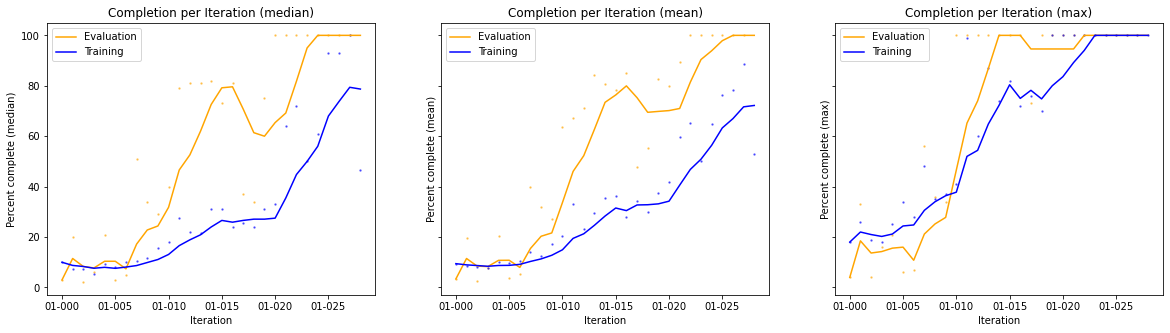

In [55]:
_ = tm.plotProgress(method=['median','mean','max'], rolling_average=5, figsize=(20,5), rounds=rounds[:,0])

### Best laps

The following rounds will show the fastest 5 training and evaluation laps.

In [12]:
train_complete_lr = train[(train['round']>(NUM_ROUNDS-1)) & (train['complete']==1)]
display(train_complete_lr.nsmallest(5,['time']))

,r-i,round,iteration,master_iteration,episode,r-e,worker,trial,phase,reward,completion,time,complete,start_time
537,01-021,1,21,21,433,1-0433,0,13,training,165,100,14.195,1,2402816
550,01-022,1,22,22,441,1-0441,0,1,training,147,100,14.327,1,2553282
635,01-025,1,25,25,511,1-0511,0,11,training,148,100,14.466,1,3483023
626,01-025,1,25,25,502,1-0502,0,2,training,141,100,14.471,1,3376153
489,01-019,1,19,19,395,1-0395,0,15,training,144,100,14.672,1,1986284


In [13]:
eval_complete_lr = ev[(ev['round']>(NUM_ROUNDS-1)) & (ev['complete']==1)]
display(eval_complete_lr.nsmallest(5,['time']))

,r-i,round,iteration,master_iteration,episode,r-e,worker,trial,phase,reward,completion,time,complete,start_time
323,01-012,1,12,12,260,1-0260,0,20,evaluation,139,100,14.602,1,939204
372,01-014,1,14,14,300,1-0300,0,20,evaluation,155,100,14.928,1,1255814
272,01-010,1,10,10,220,1-0220,0,20,evaluation,150,100,15.045,1,652551
348,01-013,1,13,13,280,1-0280,0,20,evaluation,159,100,15.053,1,1091954
295,01-011,1,11,11,240,1-0240,0,20,evaluation,156,100,15.272,1,788199


### Best lap progression

The below plot will show how the best laps for training and evaluation changes over time. This is useful to see if your model gets faster over time.

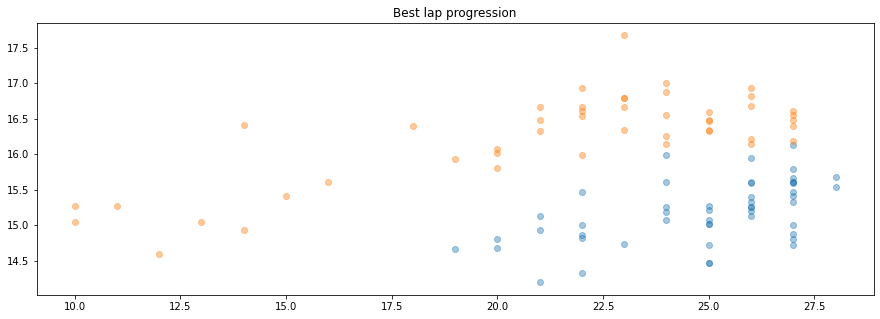

In [48]:
plt.figure(figsize=(15,5))
plt.title('Best lap progression')
plt.scatter(train_complete_lr['master_iteration'],train_complete_lr['time'],alpha=0.4)
plt.scatter(eval_complete_lr['master_iteration'],eval_complete_lr['time'],alpha=0.4)
plt.show()

### Lap progress

The below shows the completion for each training and evaluation episode.

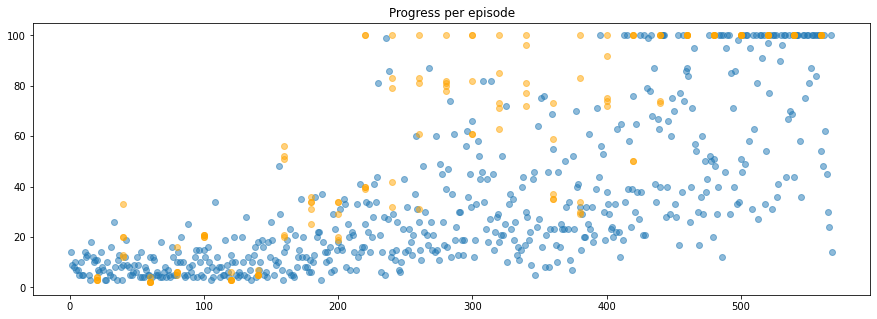

In [49]:
plt.figure(figsize=(15,5))
plt.title('Progress per episode')
train_r = train[train['round']==NUM_ROUNDS]
eval_r = ev[ev['round']==NUM_ROUNDS]
plt.scatter(train_r['episode'],train_r['completion'],alpha=0.5)
plt.scatter(eval_r['episode'],eval_r['completion'],c='orange',alpha=0.5)
plt.show()

## Robomaker Log Analysis
If the training status is COMPLETED it is also possible to directly load the Robomaker logfile.
Here we only provide a brief summary of the analysis. See `Training_analysis.ipynb` for more details.

### Load log file

In [21]:
if training_job_status == "COMPLETED":
    df = ch.get_training_log_robomaker(model_arn)
else:
    df = pd.DataFrame()

simulation_agg = au.simulation_agg(df)
complete_ones = simulation_agg[simulation_agg['progress'] == 100]

new reward not found, using reward as its values


### Analysis

Number of episodes =  563
Number of iterations =  29


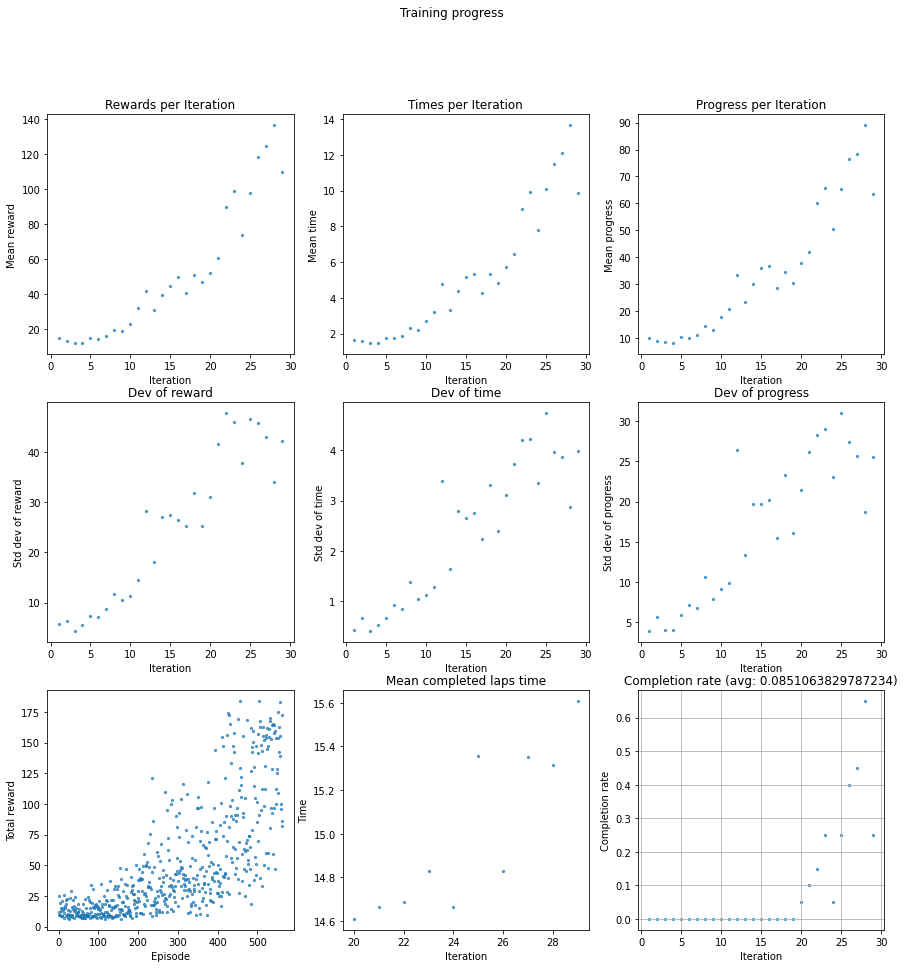

<Figure size 432x288 with 0 Axes>

In [23]:
au.analyze_training_progress(simulation_agg, title='Training progress')

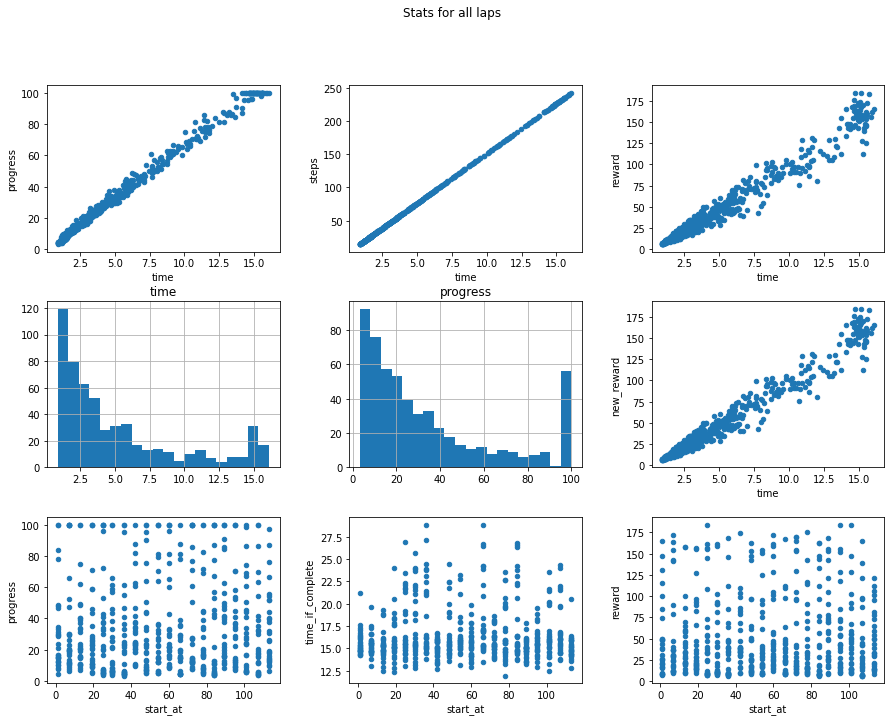

<Figure size 432x288 with 0 Axes>

In [24]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

In [25]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile
432,22,432,213,72,100.0,14.128,165.300,1.248826,165.300,14.128,165.300,4th
440,23,440,215,1,100.0,14.267,147.100,1.218605,147.100,14.267,147.100,4th
501,26,501,217,7,100.0,14.402,141.403,1.179724,141.403,14.402,141.403,5th
510,26,510,217,60,100.0,14.406,147.707,1.294931,147.707,14.406,147.707,5th
412,21,412,220,72,100.0,14.606,154.700,1.268182,154.700,14.606,154.700,4th
